In [26]:
import numpy as np
import pyedflib

import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
from sklearn.model_selection import train_test_split, KFold
import random

# Choose EEG or EMG

In [19]:
# Choose if you want to look at EEG or EMG data

#data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
data_type = "EMG"

In [20]:
# choose individuum
subject = "m294"

# Import Data

In [95]:
label_list = [0, 1, 2, 3, 4]

data_type_list = ["EEG", "EMG"]

subject_list = ["m292", "m294"]

In [22]:
# EEG & EMG data
data = {}

for label in label_list:
    data[label] = pd.read_csv("Data/"+str(subject)+"/run0"+str(label)+"/Time_Series_Data.csv")

# Preprocessing

## Segmenting Data

In [23]:
def segment_data(df, segment_size, step_size = 2):
    """
    Segments time-series data into EEG and EMG segments.

    Parameters:
    - df (DataFrame): The input dataframe containing the columns "Time", "EEG" and "EMG".
    - segment_size (float): The desired size of each segment in seconds.
    - step_size (float, optional): The step size of "Time" in milliseconds. Default is 2 millisecond.

    Returns:
    Tuple of two lists:
    - List of EEG segments.
    - List of EMG segments.
    """

    n_segments = int(df["time"].iloc[-1]) // segment_size
    eeg_segments = []
    emg_segments = []

    for i in range(n_segments):
        start_idx = int(i* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df.iloc[start_idx:end_idx]
        eeg_segments.append(list(segment["voltage"]))
        emg_segments.append(list(segment["emg"]))

    return eeg_segments, emg_segments

In [482]:
# Segment the data
segment_size = 4  # seconds
eeg_segments = {}
emg_segments = {}

for label in label_list:
    eeg_segments[label], emg_segments[label] = segment_data(data[label], segment_size, step_size = 2)

In [483]:
if data_type == "EEG":
    segments = eeg_segments
else:
    segments = emg_segments

## Cross Validation

### Choose parameters

In [484]:
# Choose size of final test set for classification at later step (recommended: 0.2-0.3)

test_size = 0.3

In [34]:
# Choose number of folds for Cross Validation of the training/validation data

n_folds = 5

### Choose Train and Test Data Indices for Test Set and for Each Fold

In [99]:
def compute_test_set_indices(label_list, segments, test_size):
    total_data_length = 0

    for label in label_list:
        total_data_length += len(segments[label])

    train_indices_dict = {}
    test_indices_dict = {}
    all_indices_dict = {}


    for label in label_list:
        data_length = len(segments[label])
        indices = np.arange(data_length)

        # This weird reshaping will later allow us to handle train/test indices of the final test set
        # splitting and the Cross Validation sets the same way
        # Both of these dictionaries will only contain one key, 0, as if there would be only one fold
        train_indices_dict[label] = {}
        test_indices_dict[label] = {}

        _, _, _, _, train_indices_dict[label][0], test_indices_dict[label][0] = train_test_split(segments[label], [label]*data_length, indices, test_size=test_size, random_state=32)

        all_indices_dict[label] = np.concatenate((train_indices_dict[label][0], test_indices_dict[label][0]))


    return train_indices_dict, test_indices_dict, all_indices_dict


# Compute indices for final test set
train_indices_dict, test_indices_dict, all_indices_dict = compute_test_set_indices(label_list, segments, test_size)

In [57]:
def compute_validation_set_indices_for_all_folds(label_list, segments, train_indices_dict, n_folds):

    # Initialize Cross Validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    total_data_length = 0

    # Dictionary with all data that is not in the final test set 
    # for each label
    train_data = {}

    for label in label_list:
        train_data[label] = [segments[label][idx] for idx in train_indices_dict[label]]
        total_data_length += len(train_data[label])

    train_indices_dict_for_folds = {}
    validation_indices_dict_for_folds = {}

    for label in label_list:
        data_length = len(train_data[label])
        indices = np.arange(data_length)

        # Initialize dictionary of indices for each label
        train_indices_dict_for_folds[label] = {}
        validation_indices_dict_for_folds[label] = {}
        
        # Create different indices for different folds
        for fold, (train_indices, test_indices) in enumerate(kf.split(train_data[label])):

            # Save indices for each label and fold
            train_indices_dict_for_folds[label][fold] = train_indices
        
            validation_indices_dict_for_folds[label][fold] = test_indices

    return train_indices_dict_for_folds, validation_indices_dict_for_folds

train_indices_dict_for_folds, validation_indices_dict_for_folds = compute_validation_set_indices_for_all_folds(label_list, segments, train_indices_dict, n_folds)

## Find outliers label them as -1

In [60]:
def concatenate_segments_for_each_label(label_list, segments, all_indices_dict):

    # Save the segments of each label for finding outliers

    label_segments = {} # Addionally 
    time_series_per_label = {}

    for label in label_list:
        ts_segments = []
        time_series = []
        for idx in all_indices_dict[label]:   
            # Later use for finding outliers
            ts_segments.append(segments[label][idx]) # segment
            time_series.extend(segments[label][idx]) # flat TS

        label_segments[label] = ts_segments
        time_series_per_label[label] = time_series

    
    # Additionally save all segments together
    all_segments = np.array([])
    
    for label in label_list:
        all_segments = np.append(all_segments, segments[label])

    return label_segments, time_series_per_label, all_segments


label_segments, time_series_per_label, all_segments = concatenate_segments_for_each_label(label_list, segments, all_indices_dict)

In [62]:
def detect_artifacts(segments_of_our_label, all_segments, indices_of_our_label, threshold):
    
    # Calculate the mean and standard deviation of the maximum absolute value in each segment
    # of all time series

    all_mav = []  # maximal absolute values of all segments
    
    for segment in all_segments:
        all_mav.append(np.max(np.abs(segment)))

    mean = np.mean(all_mav)
    std = np.std(all_mav)

    mav_of_our_label = [] # maximal absolute values of all segments of our labels
    
    for segment in segments_of_our_label:
        mav_of_our_label.append(np.max(np.abs(segment)))
    
    # Calculate the Z-scores for each data point
    z_scores = (mav_of_our_label - mean) / std
          
    # Find data points with Z-scores above the threshold (outliers)
    outliers_indices = np.where(np.abs(z_scores) > threshold)[0]

    outliers_indices_in_complete_data = [indices_of_our_label[idx] for idx in outliers_indices]

    return outliers_indices, outliers_indices_in_complete_data # TODO second output probably not neccessary 

In [63]:
outlier_indices = {}
outliers_indices_in_complete_data = {}

for label in label_list:
    outlier_indices[label], outliers_indices_in_complete_data[label] = detect_artifacts(segments[label], \
                                                                                all_segments, all_indices_dict[label], threshold=17)

### Do a check

In [79]:
# TODO redo this for the new data and also for the case that there are no outliers

# Label to check
label_to_check = 0

outlier_indices[label_to_check]

array([], dtype=int64)

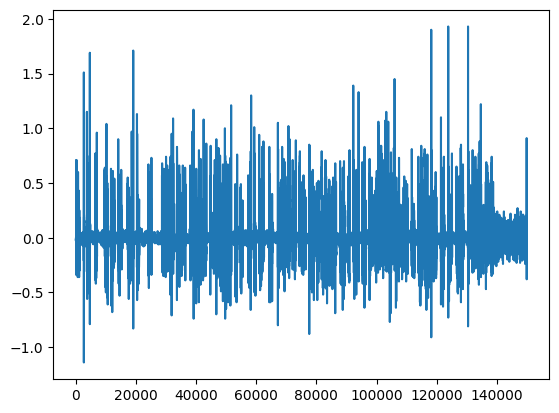

In [80]:
import matplotlib.pyplot as plt

plt.plot(data[label_to_check]["voltage"])

The first dataset does not have outliers for any label.

In [81]:
outlier_indices

{0: array([], dtype=int64),
 1: array([35, 36, 38]),
 2: array([], dtype=int64),
 3: array([], dtype=int64),
 4: array([], dtype=int64)}

In [82]:
all_mav = []  # maximal absolute values of all segments

for segment in label_segments[label_to_check]:
    all_mav.append(np.max(np.abs(segment)))

num_outliers = len(outlier_indices[label_to_check])
idx = np.argpartition(all_mav, -num_outliers)
print(idx[-num_outliers:])

[10  1  2  3  4  5  6  7  8  9  0 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]


The indices of the outliers found by both methods are exactly the same.

### Relabel outliers as -1

In [83]:
def handle_outliers(train_indices_dict, test_indices_dict, all_indices_dict, outliers_indices_in_complete_data, label_list, num_outliers):
    if num_outliers > 0:
        for label in label_list:
            for idx in outliers_indices_in_complete_data[label]:
                # Convert to NumPy arrays for easier manipulation
                train_indices_label = np.array(train_indices_dict[label])
                test_indices_label = np.array(test_indices_dict[label])
                all_indices_label = np.array(all_indices_dict[label])

                # Use boolean indexing to remove elements
                train_indices_dict[label] = train_indices_label[~(train_indices_label == idx)]
                train_indices_dict[-1] = np.append(train_indices_dict[-1], idx)

                test_indices_dict[label] = test_indices_label[~(test_indices_label == idx)]
                test_indices_dict[-1] = np.append(test_indices_dict[-1], idx)

                all_indices_dict[label] = all_indices_label[~(all_indices_label == idx)]
                all_indices_dict[-1] = np.append(all_indices_dict[-1], idx)

# Example usage:
# Call the function with your specific dictionaries and values
handle_outliers(train_indices_dict, test_indices_dict, all_indices_dict, outliers_indices_in_complete_data, label_list, num_outliers)


In [84]:
def save_segments_for_label(label, all_indices_dict, segments, output_directory='Data/'):
    time_series = []
    for idx in all_indices_dict[label]:
        # Save for data exploration
        time_series.extend(segments[label][idx])

    np.save(output_directory + 'Segments_for_Label_' + str(label) + '.npy', np.array(time_series, dtype=object), allow_pickle=True)

for label in label_list:
    save_segments_for_label(label, all_indices_dict, segments)


# Persistence Diagrams

## Finding the optimal embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [100]:
# Initialise the embedding
max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [101]:
def find_optimal_parameters(embedder, segments, max_index, iterations = 8):
    """
    Finds (approximate) optimal embedding parameters by averaging optimal parameters of random segments.

    Parameters:
    - embedder (object): defined by SingleTakensEmbedding() or similar
    - segments (list of lists): Complete EEG/EMG segments
    - max_index (int): How many segments there are
    - iteratiors (int): How many random indices to sample

    Returns:
    Tuple of two floats:
    - Average optimal embedding dimension
    - Average optimal time delay
    """


    optimal_embeddings_dimensions = []
    optimal_time_delays = []
    
    for _ in range(iterations):
        random_index = random.randint(0, max_index)
        embedding = embedder.fit_transform(segments[random_index])
        
         # append optimal embedding dimension for this segment
        optimal_embeddings_dimensions.append(embedder.dimension_)

        # append optimal time delay for this segment
        optimal_time_delays.append(embedder.time_delay_)

        print("The optimal embedding dimension is " + str(np.mean(optimal_embeddings_dimensions)) + 
              " and the optimal time delay is " + str(np.mean(optimal_time_delays)))
        
        return int(np.mean(optimal_embeddings_dimensions)), int(np.mean(optimal_time_delays))

In [102]:
# Compute optimal embedding parameters

all_segments = []

for label in label_list:
    all_segments.extend(segments[label])
    

embedding_dimension, embedding_time_delay = find_optimal_parameters(embedder, all_segments, len(all_segments), iterations = 8)

The optimal embedding dimension is 2.0 and the optimal time delay is 11.0


## Creating Persistence Diagrams

In [103]:
# Setting parameters for point cloud embeddings

#embedding_dimension= 3 # for data exploration
stride = 10

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay, # computed above
    dimension=embedding_dimension, # computed above
    stride=stride,
)

In [104]:
# We will look at 0, 1 and 2 dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing Points Clouds and Persistence Diagrams

In [128]:
def compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, all_indices_dict, label):

    time_delay_embeddings[label] = {}
    persistence_diagrams[label] = {}

    # Compute embeddings and diagrams for the complete data
    for label_idx in all_indices_dict[label]:
        time_delay_embeddings[label][label_idx] = embedder.fit_transform(segments[label][label_idx])[None, :, :] # Reshape
        persistence_diagrams[label][label_idx] = persistence.fit_transform(time_delay_embeddings[label][label_idx])

    
    return time_delay_embeddings, persistence_diagrams

In [129]:
# Compute embeddings and persistence diagrams for the complete data

time_delay_embeddings = {}
persistence_diagrams = {}

for label in label_list:
    time_delay_embeddings, persistence_diagrams = compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, all_indices_dict, label)

### Split into train and test sets

In [132]:
def split_embeddings_and_diagrams(time_delay_embeddings, persistence_diagrams, train_indices_dict, test_indices_dict, label):

    # Initialize dictionaries which will contain a list of train and test embeddings 
    # with the folds as keys
    train_embeddings = {}
    test_embeddings = {}
    for fold_idx in range(len(train_indices_dict[0])):
        # Initialize Point cloud embeddings for each fold
        train_embeddings[fold_idx] = [] # train set
        test_embeddings[fold_idx]  = [] # test set
        
        # Initalize persistence diagrams for each fold
        train_persistence_diagrams[fold_idx]  = [] # train set
        test_persistence_diagrams[fold_idx]  = [] # test set


    # Loop through the first train data segments with our label
    for label_idx in train_indices_dict[label]:
        # Loop through folds (only one fold in case of final test)
        for fold_idx in range(len(train_indices_dict[label])):
            train_embeddings[fold_idx].append(time_delay_embeddings[label][label_idx][0])
            train_persistence_diagrams[fold_idx] .append(persistence_diagrams[label][label_idx][0])

    # Loop through the first test data segments with our label
    for label_idx in test_indices_dict[label]:  
        # Loop through folds (only one fold in case of final test)
        for fold_idx in range(len(train_indices_dict[label])):
            test_embeddings[fold_idx] .append(time_delay_embeddings[label][label_idx][0])
            test_persistence_diagrams[fold_idx].append(persistence_diagrams[label][label_idx][0])


    return train_embeddings, test_embeddings, train_persistence_diagrams, test_persistence_diagrams

In [133]:
# Retrieve embeddings and persistence diagrams for the final test set

test_embeddings = {}

test_persistence_diagrams = {}

for label in label_list:
    _, test_embeddings[label], _, test_persistence_diagrams[label] = \
    split_embeddings_and_diagrams(time_delay_embeddings, persistence_diagrams, train_indices_dict, test_indices_dict, label)

In [136]:
# For the train/validation data, compute different train/validation indices for each fold

train_embeddings = {}
validation_embeddings = {}

train_persistence_diagrams = {}
validation_persistence_diagrams = {}

for label in label_list:
    train_embeddings[label], validation_embeddings[label], train_persistence_diagrams[label], validation_persistence_diagrams[label] = \
    split_embeddings_and_diagrams(time_delay_embeddings, persistence_diagrams, train_indices_dict_for_folds, validation_indices_dict_for_folds, label = label)

## Cutting off noise

For some analyses, we will need to compare persistence diagrams (pairwise). Giotto TDA needs all diagrams to have the same length for this (to have the same amount of holes). We will therefore cut off some "noise" (holes with low persistence) such that all shortened persistence diagrams have the same length.

In [ ]:
# Set number of holes of each dimension that are supposed to be kept
if data_type == "EEG":
    no_holes_per_dimension = [63, 37, 2] 
elif data_type == "EMG":
    no_holes_per_dimension = [15, 5, 1]

In [ ]:
def cut_diagrams(persistence_diagrams, no_holes_per_dimension):
    """    Cuts diagrams to the dimensions no_holes_per_dimension and removes diagrams smaller than that.

    Parameters:
    - persistence_diagrams (list of lists): list of persistence diagrams
    - no_holes_per_dimension (list): maximal dimension the persistence diagrams should have, e.g.
    [120, 70, 10] for 120 holes of dimension 0, 70 of dimension 1 and 10 of dimension 2

    Returns:
    Tuple of two lists:
    - shortened diagrams
    - indices of diagrams that were to small and were removed from the list of shortened diagrams
    """
        
    shortened_diagrams = [] # list of diagrams in which non-signicant holes were cut off
    removed_indices = [] # List of indices of the diagrams that are smaller than no_holes_per_dimension and will not be considered

    for diagram_idx, diagram in enumerate(persistence_diagrams): 
        
        most_significant_holes_per_diagram = [] # Holes that are not noise
        should_be_appended = True # Boolean if the diagram index will be added to removed index (False) or not (True)
        holes = {} # Dictionary which will save all holes (values) of each dimension (keys) for each diagram
        
        for hole_dimension, number_of_holes in zip(range(3), no_holes_per_dimension):
            
            # the third entry of each point (hole) in a diagram indicates its dimensionality
            holes[hole_dimension] = diagram[np.where(diagram[:, 2] == hole_dimension)[0]]

            # If the number of holes of this dimension that are supposed to be kept is larger than the number of holes of the diagram
            if number_of_holes > len(holes[hole_dimension]):
                print("Diagram " + str(diagram_idx) + " is shorter than the shortened diagrams, and was removed.")
                print("It has " + str(len(holes[hole_dimension])) + " holes of dimension " + str(hole_dimension))
                should_be_appended = False 
                removed_indices.append(diagram_idx) # Should be sepa rated according to dimension? or not?
                
            # The first and second entries of each hole indicate its birth and death, the difference is the persistence
            # We only want to keep as the as many holes for each dimension as we set no_holes_per_dimension to be
            large_persistence_indices = np.argsort(holes[hole_dimension][:, 0] - holes[hole_dimension][:, 1])[-number_of_holes:]
            
            # For each dimension, getting the holes with the above indices (the holes with the largest persistence)
            significant_holes_with_hole_dimension = holes[hole_dimension][large_persistence_indices, :]
            most_significant_holes_per_diagram.extend(significant_holes_with_hole_dimension)

        if should_be_appended:
            shortened_diagrams.append(most_significant_holes_per_diagram)

    return shortened_diagrams, list(set(removed_indices))

In [ ]:
train_shortened_diagrams = {}
test_shortened_diagrams = {}

removed_train_indices = {}
removed_test_indices = {}

for label in label_list:
    train_shortened_diagrams[label], removed_train_indices[label] = cut_diagrams(train_persistence_diagrams[label], no_holes_per_dimension)
    test_shortened_diagrams[label], removed_test_indices[label] = cut_diagrams(test_persistence_diagrams[label], no_holes_per_dimension)

    # Remove embeddings of diagrams that were removed 
    train_embeddings[label] =  np.delete(train_embeddings[label], removed_train_indices[label], 0)
    test_embeddings[label] =  np.delete(test_embeddings[label], removed_test_indices[label], 0)

## Save persistence diagrams and embeddings

In [141]:
for label in label_list:
    # Final Test set
    np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Test/'+str(data_type)+'/PD'+str(label)+'.npy', \
            np.array(test_persistence_diagrams[label], dtype=object), allow_pickle=True)

    np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Test/'+str(data_type)+'/Embeddings_'+str(label)+\
            '_Dim'+str(embedding_dimension)+'.npy', np.array(test_embeddings[label], dtype=object), allow_pickle=True)


    # Folds
    for fold in range(n_folds):
        # Train Set
        np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Train/'+str(data_type)+'/Fold_'+str(fold)+'_Train_PD'+str(label)+'.npy', \
                np.array(train_persistence_diagrams[label][fold], dtype=object), allow_pickle=True)

        np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Train/'+str(data_type)+'/Fold_'+str(fold)+'_Train_Embeddings_'+str(label)+'.npy', \
                np.array(train_embeddings[label][fold], dtype=object), allow_pickle=True)


        # Validation Set
        np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Train/'+str(data_type)+'/Fold_'+str(fold)+'_Validation_PD'+str(label)+'.npy', \
                np.array(validation_persistence_diagrams[label][fold], dtype=object), allow_pickle=True)

        np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Train/'+str(data_type)+'/Fold_'+str(fold)+'_Validation_Embeddings_'+str(label)+'.npy', \
                np.array(validation_embeddings[label][fold], dtype=object), allow_pickle=True)


    # Shortened Persistence diagrams
    #np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Train/'+str(data_type)+'/Shortened_Diagrams'+str(label)+'.npy', np.array(train_shortened_diagrams[label], dtype=object), allow_pickle=True)
    #np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Test/'+str(data_type)+'/Shortened_Diagrams'+str(label)+'.npy', np.array(test_shortened_diagrams[label], dtype=object), allow_pickle=True)

    # Removed indices
    #np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Train/'+str(data_type)+'/Removed_Indices'+str(label)+'.npy', np.array(removed_train_indices[label], dtype=object), allow_pickle=True)
    #np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/Test/'+str(data_type)+'/Removed_Indices'+str(label)+'.npy', np.array(removed_test_indices[label], dtype=object), allow_pickle=True)
    